In [1]:
# importing some libraries we need in this part
import scipy.io
import numpy as np
import os
from collections import defaultdict, Counter
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from cmath import pi
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from scipy.signal import stft
from scipy import signal
import numpy as np

In [2]:
# Data for this part:
with open('Data/trainset.pickle', 'rb') as handle:
    trainset = pickle.load(handle)


# Load the CSI and ground truth for the advanced task
CSI = trainset['CSI'][5]  # This assumes that the sixth dataset corresponds to your advanced task
groundtruth = trainset['groundtruth'][5]  # Loading the ground-truth
experiment_name = trainset['ex_name'][5][:-4]
print("The name of this experiment: ", experiment_name)

The name of this experiment:  breath_bpm12-24-12_ax200_cbw20_fs100_2x2_1_220928_170213


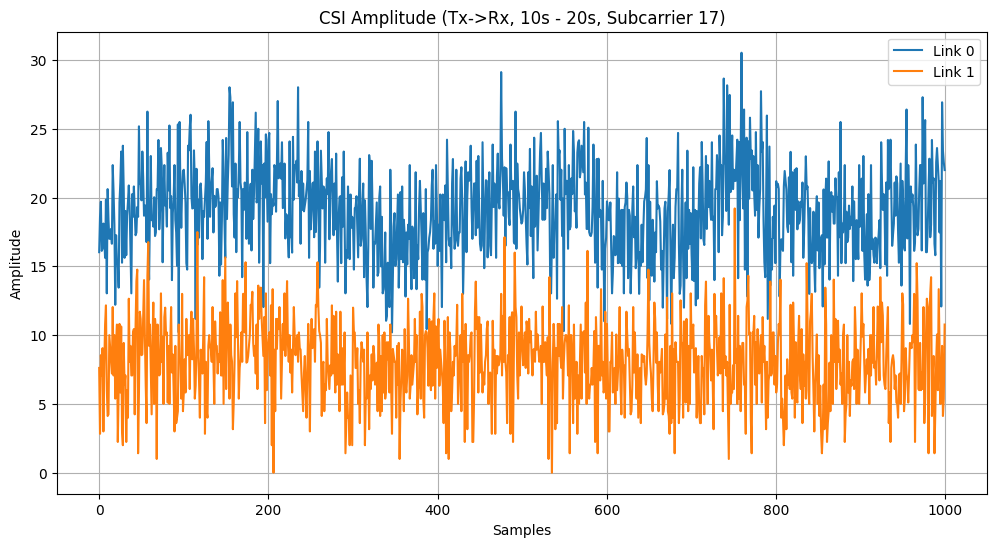

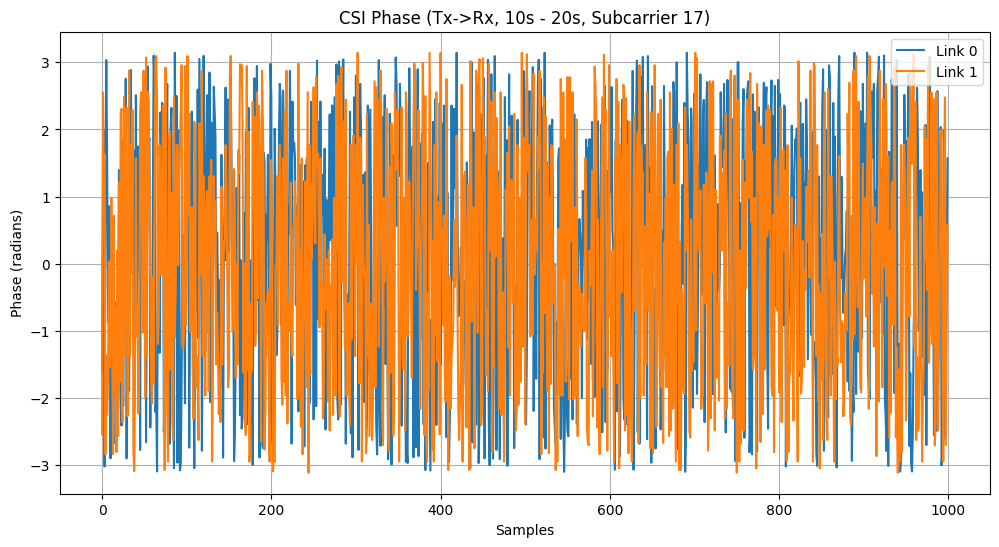

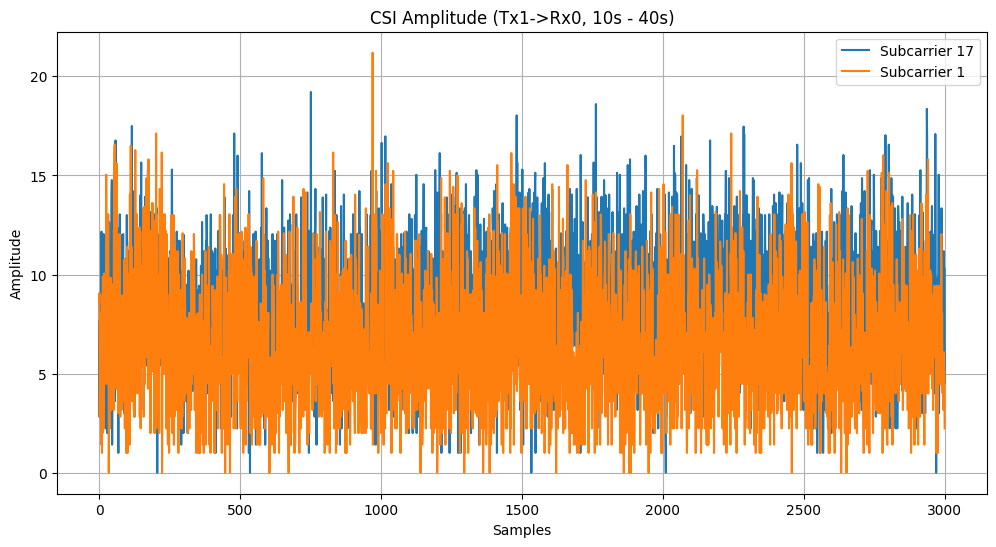

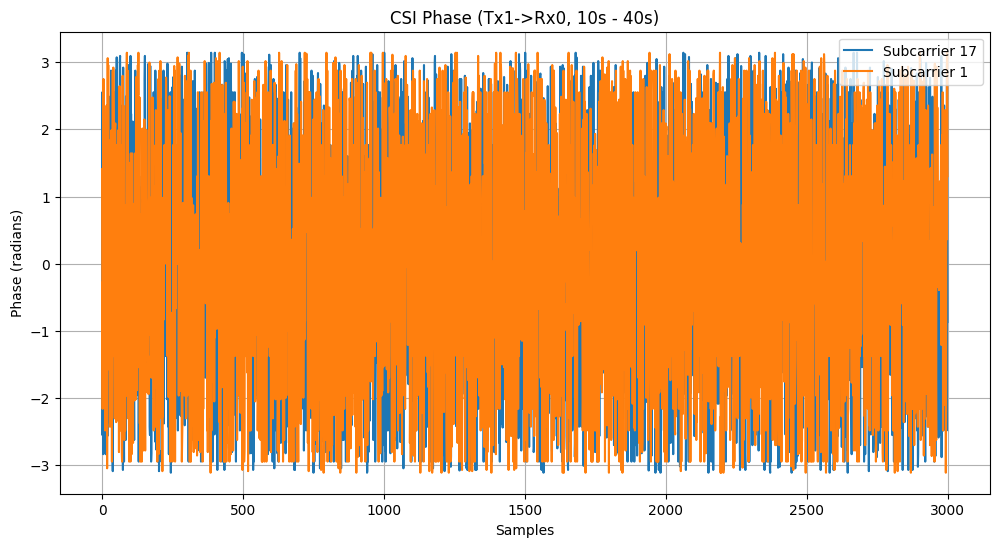

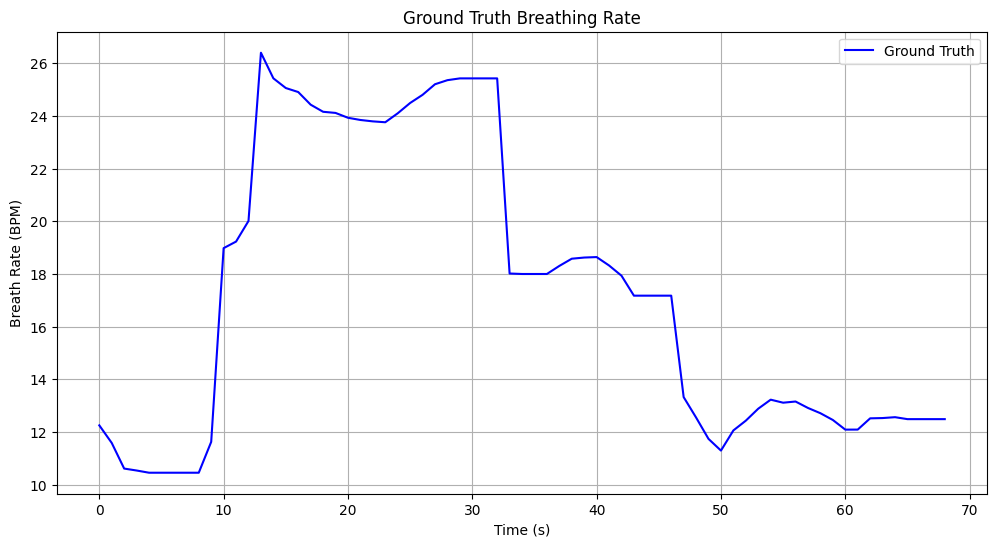

In [3]:
def DataVisualization(CSI, groundtruth):
    time_range_short = slice(1000, 2000)  # 10s to 20s
    time_range_long = slice(1000, 4000)   # 10s to 40s

    # STEP #1: Visualize the CSI from 10s - 20s on subcarrier #17 of all links
    plt.figure(figsize=(12, 6))
    for link in range(2):  # For Tx->Rx pairs
        amplitude_data = np.abs(CSI[time_range_short, 17, link, 0])
        # Check if the resulting array is 1D or 2D and adjust accordingly
        if amplitude_data.ndim == 1:
            plt.plot(amplitude_data, label=f'Link {link}')
        else:
            plt.plot(amplitude_data.mean(axis=1), label=f'Link {link}')
    plt.title('CSI Amplitude (Tx->Rx, 10s - 20s, Subcarrier 17)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

    # 1.2: Visualize the phase
    plt.figure(figsize=(12, 6))
    for link in range(2):
        phase_data = np.angle(CSI[time_range_short, 17, link, 0])
        if phase_data.ndim == 1:
            plt.plot(phase_data, label=f'Link {link}')
        else:
            plt.plot(phase_data.mean(axis=1), label=f'Link {link}')
    plt.title('CSI Phase (Tx->Rx, 10s - 20s, Subcarrier 17)')
    plt.xlabel('Samples')
    plt.ylabel('Phase (radians)')
    plt.legend()
    plt.grid()
    plt.show()

    # STEP #2: Visualize the CSI from 10s - 40s on subcarrier #17 and #1 of the link (Tx1->Rx0)
    plt.figure(figsize=(12, 6))
    for subcarrier in [17, 1]:
        amplitude_data = np.abs(CSI[time_range_long, subcarrier, 1, 0])
        if amplitude_data.ndim == 1:
            plt.plot(amplitude_data, label=f'Subcarrier {subcarrier}')
        else:
            plt.plot(amplitude_data.mean(axis=1), label=f'Subcarrier {subcarrier}')
    plt.title('CSI Amplitude (Tx1->Rx0, 10s - 40s)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

    # 2.2: Visualize the phase
    plt.figure(figsize=(12, 6))
    for subcarrier in [17, 1]:
        phase_data = np.angle(CSI[time_range_long, subcarrier, 1, 0])
        if phase_data.ndim == 1:
            plt.plot(phase_data, label=f'Subcarrier {subcarrier}')
        else:
            plt.plot(phase_data.mean(axis=1), label=f'Subcarrier {subcarrier}')
    plt.title('CSI Phase (Tx1->Rx0, 10s - 40s)')
    plt.xlabel('Samples')
    plt.ylabel('Phase (radians)')
    plt.legend()
    plt.grid()
    plt.show()

    # STEP #3: Visualize the ground-truth
    plt.figure(figsize=(12, 6))
    plt.plot(groundtruth, label='Ground Truth', color='blue')
    plt.title('Ground Truth Breathing Rate')
    plt.xlabel('Time (s)')
    plt.ylabel('Breath Rate (BPM)')
    plt.legend()
    plt.grid()
    plt.show()

# Call the DataVisualization function
DataVisualization(CSI, groundtruth)


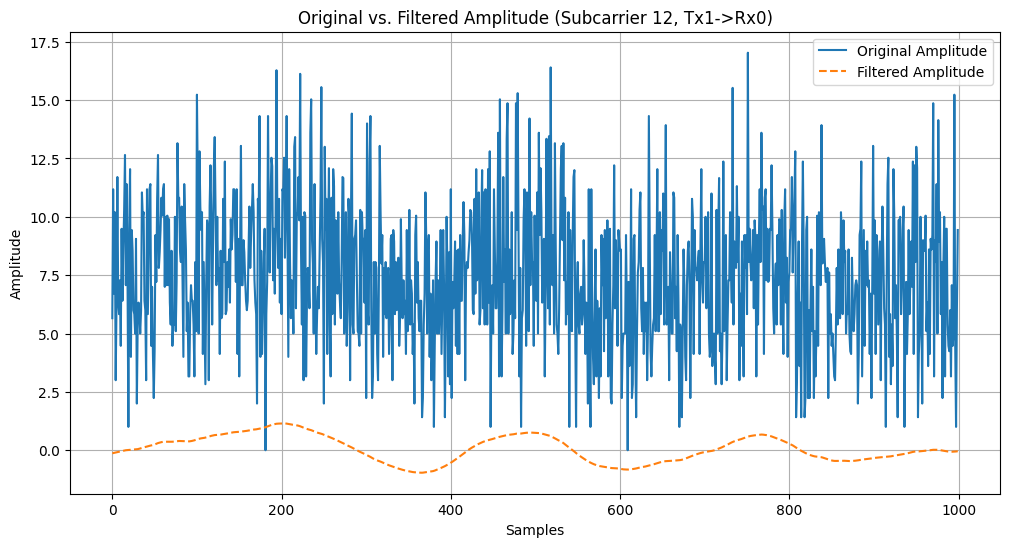

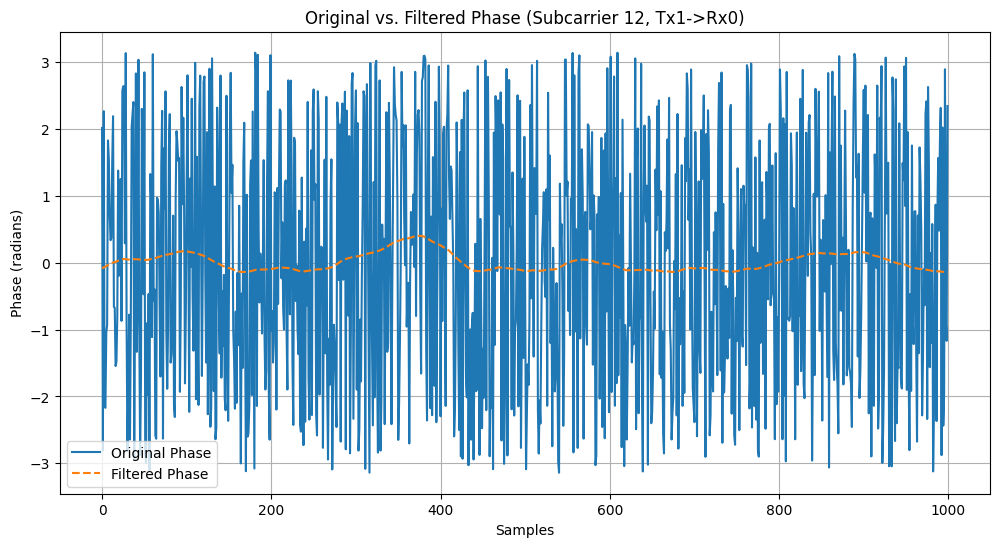

In [4]:
# Preprocessing

# Phase Cleaning
# the sanitization function is given to eliminate the phase offset
from cmath import pi


def sanitization(x):
    F = len(x)
    phase = np.angle(x)
    phase = np.unwrap(phase)
    a = (phase[-1] - phase[0]) / (2 * pi * F)
    b = sum(phase) / F

    firstpart = (np.arange(F) + 1) * a
    secondpart = np.ones(F) * b
    phase = phase - firstpart - secondpart

    return x * np.exp(1j * phase)


def phase_cleaning(CSI):
    for i in range(CSI.shape[0]):
        CSI[i, :, 0, 0] = sanitization(CSI[i, :, 0, 0])
        CSI[i, :, 0, 1] = sanitization(CSI[i, :, 0, 1])
        CSI[i, :, 1, 0] = sanitization(CSI[i, :, 1, 0])
        CSI[i, :, 1, 1] = sanitization(CSI[i, :, 1, 1])
    return CSI


from scipy import signal
import matplotlib.pyplot as plt

def Preprocessing(CSI):
    # Step 1: Clean the phase
    CSI = phase_cleaning(CSI)
    
    # Step 2: Calculate amplitude and phase
    CSI_amplitude = np.abs(CSI)
    CSI_phase = np.angle(CSI)

    # Step 3: Filter design - Butterworth bandpass filter
    fs = 100  # Sampling frequency in Hz
    lowcut = 0.1  # Lower cutoff frequency (BPM converted to Hz)
    highcut = 0.5  # Upper cutoff frequency (BPM converted to Hz)
    
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(1, [low, high], btype='band')

    # Step 4: Filter amplitude and phase
    filtered_amplitude = signal.filtfilt(b, a, CSI_amplitude, axis=0)
    filtered_phase = signal.filtfilt(b, a, CSI_phase, axis=0)

    # Visualizations
    # 4.3: Visualize original and denoised amplitude
    time_range_short = slice(1000, 2000)  # 10s - 20s
    plt.figure(figsize=(12, 6))
    plt.plot(CSI_amplitude[time_range_short, 12, 1, 0], label='Original Amplitude')
    plt.plot(filtered_amplitude[time_range_short, 12, 1, 0], label='Filtered Amplitude', linestyle='--')
    plt.title('Original vs. Filtered Amplitude (Subcarrier 12, Tx1->Rx0)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

    # 4.3.2: Visualize original and denoised phase
    plt.figure(figsize=(12, 6))
    plt.plot(CSI_phase[time_range_short, 12, 1, 0], label='Original Phase')
    plt.plot(filtered_phase[time_range_short, 12, 1, 0], label='Filtered Phase', linestyle='--')
    plt.title('Original vs. Filtered Phase (Subcarrier 12, Tx1->Rx0)')
    plt.xlabel('Samples')
    plt.ylabel('Phase (radians)')
    plt.legend()
    plt.grid()
    plt.show()

    # Return the filtered complex CSI
    return filtered_amplitude * np.exp(1j * filtered_phase)

# Call Preprocessing and visualize
processed_CSI = Preprocessing(CSI)


In [5]:
from scipy.signal import butter, filtfilt

def advanced_filter(data, lowcut=0.5, highcut=2.0, fs=100, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def FeatureDetection(aggregated_CSI):
    # Apply the advanced filter to the aggregated data
    filtered_CSI = advanced_filter(aggregated_CSI)
    f, t, Zxx = stft(filtered_CSI, fs=100, nperseg=256)
    Zxx_magnitude = np.abs(Zxx)

    # Visualizing the STFT feature
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t, f, Zxx_magnitude, shading='gouraud')
    plt.title('STFT Magnitude after Filtering')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Magnitude')
    plt.grid()
    plt.show()

    return Zxx

# Call Aggregation and FeatureDetection
aggregated_CSI = Aggregation(processed_CSI)
feature = FeatureDetection(aggregated_CSI)


NameError: name 'Aggregation' is not defined